# Fit terrain mesh from rover images


In [2]:
import os
import cv2
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from pytorch3d.vis.plotly_vis import plot_scene

from pytorch3d.renderer import (
    PointLights,
    FoVPerspectiveCameras,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

from pytorch3d_utils import structured_grid_to_pytorch3d_mesh
from lac.utils.plotting import plot_poses
from lac.utils.frames import get_cam_pose_rover, CAMERA_TO_OPENCV_PASSIVE
from lac.util import load_data

%load_ext autoreload
%autoreload 2

/home/lac/miniconda3/envs/lac-dev/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
map = np.load("../../../data/heightmaps/competition/Moon_Map_01_preset_0.dat", allow_pickle=True)

mesh = structured_grid_to_pytorch3d_mesh(map[..., :3])
mesh = mesh.to(device)

In [4]:
# Render the plotly figure
fig = plot_scene({"subplot1": {"map_mesh": mesh}})
fig.update_layout(width=1200, height=700, scene=dict(aspectmode="cube"))
fig.update_layout(
    scene=dict(
        xaxis=dict(showgrid=True, showbackground=True),
        yaxis=dict(showgrid=True, showbackground=True),
        zaxis=dict(showgrid=True, showbackground=True),
    )
)
fig.show()

In [5]:
data_path = "../../../output/LocalizationAgent/map1_preset0_4m_spiral"
initial_pose, lander_pose, poses, imu_data, cam_config = load_data(data_path)

In [6]:
# Render the plotly figure
fig = plot_scene({"subplot1": {"map_mesh": mesh}})
# fig.update_layout(width=1200, height=700, scene=dict(aspectmode="cube"))
fig = plot_poses(poses[::100], fig=fig)
fig.update_layout(width=1200, height=700, scene=dict(aspectmode="data"))
fig.show()

In [7]:
def rover_pose_to_cam_pose(rover_pose, cam_name="FrontLeft"):
    camera_pose = get_cam_pose_rover(cam_name)
    camera_pose[:3, :3] = CAMERA_TO_OPENCV_PASSIVE
    return rover_pose @ camera_pose

In [11]:
R = []
T = []
target_rgb = []
cam_poses = []

start_idx = 100
end_idx = 1000
increment = 10
idxs = np.arange(start_idx, end_idx, increment)
num_views = len(idxs)

for i in idxs:
    cam_pose = rover_pose_to_cam_pose(poses[i])
    cam_poses.append(cam_pose)
    R.append(torch.tensor(cam_pose[:3, :3], device=device).float())
    T.append(torch.tensor(cam_pose[:3, 3], device=device).float())
    img_np = cv2.imread(os.path.join(data_path, "FrontLeft", f"{i}.png")) / 255.0
    new_size = (img_np.shape[1] // 2, img_np.shape[0] // 2)
    downscaled_img_np = cv2.resize(img_np, new_size, interpolation=cv2.INTER_AREA)
    target_rgb.append(torch.tensor(downscaled_img_np, device=device).float())

R = torch.stack(R)
T = torch.stack(T)
target_cameras = [
    FoVPerspectiveCameras(device=device, R=R[None, i, ...], T=T[None, i, ...])
    for i in range(num_views)
]

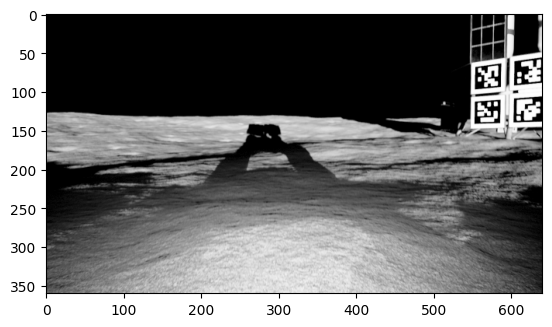

In [12]:
plt.imshow(target_rgb[0].detach().cpu().numpy())

In [ ]:
# Render the plotly figure
fig = plot_scene({"subplot1": {"map_mesh": mesh}})
# fig.update_layout(width=1200, height=700, scene=dict(aspectmode="cube"))
fig = plot_poses(cam_poses, fig=fig)
fig.update_layout(width=1200, height=700, scene=dict(aspectmode="data"))
fig.show()

In [ ]:
from lac.utils.plotting import plot_mesh_vertices_edges

fig = plot_mesh_vertices_edges(mesh)

In [13]:
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], T=T[None, 1, ...])

In [14]:
# Place a point light in front of the object. As mentioned above, the front of
# the cow is facing the -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=(360, 640),
    blur_radius=np.log(1.0 / 1e-4 - 1.0) * sigma,
    faces_per_pixel=50,
    perspective_correct=False,
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=camera, raster_settings=raster_settings_soft),
    shader=SoftPhongShader(device=device, cameras=camera, lights=lights),
)

In [15]:
verts_shape = mesh.verts_packed().shape

In [16]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 2000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh
# edge loss, mesh normal consistency, and mesh laplacian smoothing
losses = {
    "rgb": {"weight": 1.0, "values": []},
    "silhouette": {"weight": 1.0, "values": []},
    "edge": {"weight": 1.0, "values": []},
    "normal": {"weight": 0.01, "values": []},
    "laplacian": {"weight": 1.0, "values": []},
}

# For now we don't deform the mesh, and only learn the color

# Learn per vertex colors that define texture of the mesh
terrain_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([terrain_verts_rgb], lr=1.0, momentum=0.9)

In [ ]:
# Show a visualization comparing the rendered predicted mesh to the ground truth
# mesh
def visualize_prediction(
    predicted_mesh,
    renderer=renderer_textured,
    target_image=target_rgb[1],
    title="",
    silhouette=False,
):
    inds = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis("off")

In [ ]:
mesh.device

In [ ]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # # Deform the mesh
    # new_src_mesh = src_mesh.offset_verts(deform_verts)
    new_mesh = mesh.clone()

    # Add per vertex colors to texture the mesh
    new_mesh.textures = TexturesVertex(verts_features=terrain_verts_rgb)

    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    # update_mesh_shape_prior_losses(new_src_mesh, loss)

    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_textured(new_mesh, cameras=target_cameras[j], lights=lights)

        # # Squared L2 distance between the predicted silhouette and the target
        # # silhouette from our dataset
        # predicted_silhouette = images_predicted[..., 3]
        # loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        # loss["silhouette"] += loss_silhouette / num_views_per_iteration

        # Squared L2 distance between the predicted RGB image and the target
        # image from our dataset
        predicted_rgb = images_predicted[..., :3]
        loss_rgb = ((predicted_rgb - target_rgb[j]) ** 2).mean()
        loss["rgb"] += loss_rgb / num_views_per_iteration

    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(float(l.detach().cpu()))

    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)

    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(
            new_mesh, renderer=renderer_textured, title="iter: %d" % i, silhouette=False
        )

    # Optimization step
    sum_loss.backward()
    optimizer.step()